## Setup
Import necessary packages and define global variables

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import string
# import os


from yellowbrick.text import DispersionPlot
from yellowbrick.datasets import load_hobbies

from nltk.corpus.reader.plaintext import PlaintextCorpusReader
from nltk import tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

# suppress warnings about color in dispersion plots because they aren't pretty and aren't critical
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

BOOK_NUM = [1,2,3,4,5,6,7]

## Clean Data

In [2]:
titles = []
for n in BOOK_NUM:
    # if os.path.isfile("narnia_books_cleaned/book_%s.txt" % n) and os.path.getsize("narnia_books_cleaned/book_%s.txt" % n) == 0:
    write_flag = False
    with open("narnia_books/book_%s.txt" % n, "r") as input_file:
        with open("narnia_books_cleaned/book_%s.txt" % n, "r+") as output_file: 
            output_file.truncate(0)
            for line in input_file:
                # create a list of all book titles
                if "[Transcriber's note:" in line:
                    for line in input_file:
                        if line != "\n":
                            titles.append(line)
                            break
                # filter out all front and back matter
                if line == "CHAPTER I\n" or line == "Chapter I\n":
                    write_flag = True
                if "[" in line or line == "The Chronicles of Narnia\n":
                    write_flag = False
                # write line to cleaned file
                if write_flag:
                    output_file.write(line.lower())

## Compare Word Counts

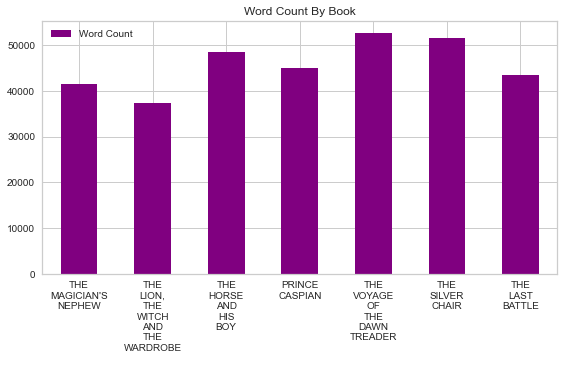

In [3]:
word_count = 0
totals = []
# get word count of each book
for n in BOOK_NUM:
    with open("narnia_books_cleaned/book_%s.txt" % n) as file:
        for line in file:
            words = line.split()
            word_count += len(words)
    totals.append(word_count)
    word_count = 0
titles = [label.replace(' ', '\n') for label in titles]
df = pd.DataFrame({' ':titles, 'Word Count': totals})
ax = df.plot.bar(x=' ', y='Word Count',rot=0, title='Word Count By Book', color='Purple')
plt.tight_layout()
plt.show()

## Main Character Dispersion

/Users/lindsaygoldberg-custer/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


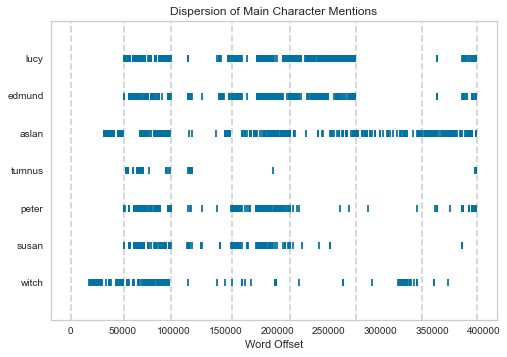

<AxesSubplot:title={'center':'Dispersion of Main Character Mentions'}, xlabel='Word Offset'>

In [4]:
char_list = ["lucy", "edmund", "aslan", "tumnus", "peter", "susan", "witch"]
word_list = [[""]]


narnia_corpus = PlaintextCorpusReader('narnia_books_cleaned', r'.\*.txt')
for n in BOOK_NUM:
    book_words = narnia_corpus.words('book_%s.txt' % n)
    word_list.append(book_words)

visualizer = DispersionPlot(list(char_list), title="Dispersion of Main Character Mentions", annotate_docs=True)
visualizer.fit(list(word_list))
visualizer.show()

## Minor Character Dispersion

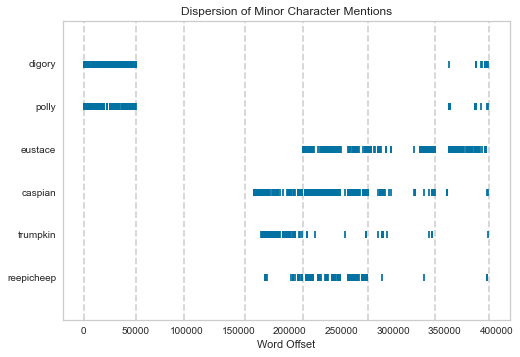

<AxesSubplot:title={'center':'Dispersion of Minor Character Mentions'}, xlabel='Word Offset'>

In [5]:
char_list = ["digory", "polly", "eustace", "caspian", "trumpkin", "reepicheep"]


visualizer = DispersionPlot(char_list, title="Dispersion of Minor Character Mentions", annotate_docs=True)
visualizer.fit(word_list)
visualizer.show()

## Most Common Words

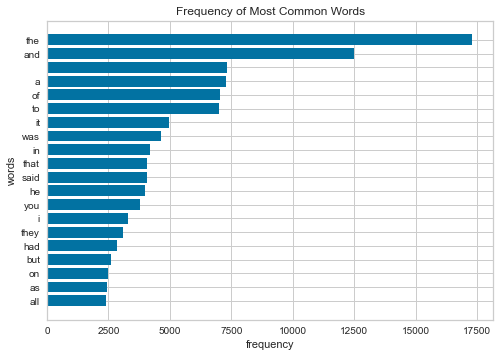

In [6]:
word_counts = dict()
for n in BOOK_NUM:
    with open("narnia_books_cleaned/book_%s.txt" % n, 'r') as file:
        lines = file.readlines()
        for line in lines:
            line = line.strip()
            line = line.lower()
            line = line.translate(line.maketrans("", "", string.punctuation))
            words = line.split(" ")
            for word in words:
                if word in word_counts:
                    word_counts[word] += 1
                else:
                    word_counts[word] = 1

word_counts = dict(sorted(word_counts.items(), key=lambda elem:elem[1], reverse=True)[:20])
plt.barh(list(word_counts.keys()), word_counts.values())
ax = plt.gca()
ax.invert_yaxis()
# plt.yticks([])
plt.xlabel("frequency")
plt.ylabel("words")
plt.title("Frequency of Most Common Words")
plt.show()

## Sentiment Analysis

Text(0.5, 0, 'Book')

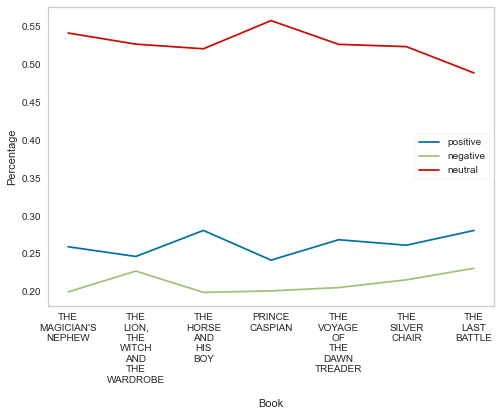

In [12]:
polarity_scores = []
sentences = []

for n in BOOK_NUM:
    with open("narnia_books_cleaned/book_%s.txt" % n, 'r') as file:
        book = file.read()
        sentences.append(tokenize.sent_tokenize(book))
        
sia = SentimentIntensityAnalyzer()        
for n in range(len(BOOK_NUM)):
    pos_count = 0
    neg_count = 0
    neu_count = 0
    for s in range(len(sentences[n])):
        sentiment_dict = sia.polarity_scores(sentences[n][s])["compound"]
        if sentiment_dict >= 0.05 :
            pos_count += 1

        elif sentiment_dict <= - 0.05 :
            neg_count += 1

        else :
            neu_count += 1
    pos_percent = pos_count / len(sentences[n])
    neg_percent = neg_count / len(sentences[n])
    neu_percent = neu_count / len(sentences[n])
    polarity_scores.append([pos_percent, neg_percent, neu_percent])

plt.plot(titles, polarity_scores)
plt.legend(["positive", "negative", "neutral"], loc=0, frameon=True)
plt.gca().grid(False)
plt.ylabel("Percentage")
plt.xlabel("Book")

## Location Count